# biosc - diagnostics: isochrones and $A(Li)$ model comparison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import bambi as bmb
import xarray as xr
import biosc
import biosc.preprocessing
import matplotlib.ticker as ticker

from pymc import HalfCauchy, Model, Normal, sample

import os
import matplotlib.cm as cm
from netCDF4 import Dataset as NetCDFFile
from scipy.stats import gaussian_kde

from biosc.preprocessing import Preprocessing
from biosc.bhm import BayesianModel

import sys
sys.path.append('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/')

import bmp
from bmp import BayesianModelPlots

In [125]:
plt.rcParams.update({'font.size': 14, 'axes.linewidth': 1, 'axes.edgecolor': 'k'})
plt.rcParams['font.family'] = 'serif'

data_file = 'test_ALi_low_clean_only_good.csv'
file = 'output_test_UCDs_low_clean_only_good_uninf.nc'
path_data = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/test_ALi_low_clean_only_good.csv'
path_models = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'
L = 10
priors = {
    'Age [Myr]': {'dist': 'uniform', 'lower': 60, 'upper': 150},
    'Distance [pc]': {'dist': 'normal', 'mu': 135, 'sigma': 20}
}
ages = [0.02, 0.08, 0.12, 0.5]
colormap = 'turbo'
plot_type = 'all'

bayesian_plots = BayesianModelPlots(data_file, priors, file, path_data, path_models, L, ages, colormap)
bayesian_plots.process_idata(plot_type=plot_type)

In [6]:
PARSEC_iso_omega_06 = np.loadtxt('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_06.dat')


In [8]:
len(PARSEC_iso_omega_06)

8284

In [14]:
with open('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_06.dat', 'r') as file:
    for i, line in enumerate(file):
        if i == 14:
            columns = line.strip().lstrip('#').split()
            break

In [15]:
PARSEC_iso_omega_06_dataframe = pd.DataFrame(PARSEC_iso_omega_06, columns=columns)


In [16]:
PARSEC_iso_omega_06_dataframe

,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,K_i45,K_i50,K_i55,K_i60,K_i65,K_i70,K_i75,K_i80,K_i85,K_i90
0,0.001547,-0.58336,6.00,0.090000,1.081690,0.090,-1.161,3.4888,3.461,0.0,...,4.939,4.939,4.939,4.939,4.939,4.939,4.939,4.939,4.939,4.939
1,0.001547,-0.58336,6.00,0.100000,1.171106,0.100,-1.062,3.4952,3.433,0.0,...,4.705,4.705,4.705,4.705,4.705,4.705,4.705,4.705,4.705,4.705
2,0.001547,-0.58336,6.00,0.118399,1.308671,0.118,-0.909,3.5052,3.393,0.0,...,4.343,4.343,4.343,4.343,4.343,4.343,4.343,4.343,4.343,4.343
3,0.001547,-0.58336,6.00,0.120000,1.319315,0.120,-0.897,3.5060,3.390,0.0,...,4.314,4.314,4.314,4.314,4.314,4.314,4.314,4.314,4.314,4.314
4,0.001547,-0.58336,6.00,0.139167,1.433940,0.139,-0.765,3.5151,3.359,0.0,...,4.001,4.001,4.001,4.001,4.001,4.001,4.001,4.001,4.001,4.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8279,0.001547,-0.58336,9.99,0.934984,2.458210,0.838,3.395,3.5441,0.095,7.0,...,-6.592,-6.592,-6.592,-6.592,-6.592,-6.592,-6.592,-6.592,-6.592,-6.592
8280,0.001547,-0.58336,9.99,0.934984,2.458210,0.838,3.406,3.5426,0.077,7.0,...,-6.630,-6.630,-6.630,-6.630,-6.630,-6.630,-6.630,-6.630,-6.630,-6.630
8281,0.001547,-0.58336,9.99,0.934985,2.458210,0.837,3.418,3.5411,0.059,7.0,...,-6.667,-6.667,-6.667,-6.667,-6.667,-6.667,-6.667,-6.667,-6.667,-6.667
8282,0.001547,-0.58336,9.99,0.934985,2.458210,0.836,3.432,3.5393,0.038,7.0,...,-6.712,-6.712,-6.712,-6.712,-6.712,-6.712,-6.712,-6.712,-6.712,-6.712


In [17]:
PARSEC_iso_omega_06_dataframe['Age [Gyr]'] = (10**(PARSEC_iso_omega_06_dataframe['logAge']))/(1e9)

In [19]:
PARSEC_iso_omega_06_dataframe.to_csv('PARSEC_iso_omega_06.csv', index=False)


In [108]:
lib = ['Gaia', '2MASS', 'PanSTARRS']

PARSEC_iso_omega_06_Phot = {}

for l in lib:
    data = np.loadtxt('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_00_'+l+'.dat')
    
    # Leer la fila 15 para obtener los nombres de las columnas
    with open('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_00_'+l+'.dat', 'r') as file:
        for i, line in enumerate(file):
            if i == 14:
                columns = line.strip().lstrip('#').split()
                break
    
    # Crear un DataFrame con los datos y los nombres de las columnas
    dataframe = pd.DataFrame(data, columns=columns)
    
    # Guardar el DataFrame en el diccionario con el nombre correspondiente
    PARSEC_iso_omega_06_Phot[l] = dataframe
    
    PARSEC_iso_omega_06_Phot[l]['Age [Gyr]'] = (10**(PARSEC_iso_omega_06_Phot[l]['logAge']))/(1e9)
    
common_columns = PARSEC_iso_omega_06_Phot['Gaia'].columns[:35]

dataframes_concatenate = [df for df in PARSEC_iso_omega_06_Phot.values()]

dataframe_final = pd.concat(dataframes_concatenate, axis=1)

dataframe_final = dataframe_final.loc[:,~dataframe_final.columns.duplicated()]

dataframe_final.to_csv('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_00_Phot.csv', index=False)

PARSEC_iso_omega_06_Phot_dict = {}

for age in dataframe_final['Age [Gyr]'].unique():
    dataframe_by_age = dataframe_final[dataframe_final['Age [Gyr]'] == age]
    PARSEC_iso_omega_06_Phot_dict[age] = dataframe_by_age


In [109]:
dataframe_final['Age [Gyr]']

0        0.002000
1        0.002000
2        0.002000
3        0.002000
4        0.002000
           ...   
41620    0.596994
41621    0.596994
41622    0.596994
41623    0.596994
41624    0.596994
Name: Age [Gyr], Length: 41625, dtype: float64

In [110]:
PARSEC_iso_omega_06_Phot['Gaia'].columns

Index(['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe',
       'logg', 'label',
       ...
       'G_RP_i50', 'G_RP_i55', 'G_RP_i60', 'G_RP_i65', 'G_RP_i70', 'G_RP_i75',
       'G_RP_i80', 'G_RP_i85', 'G_RP_i90', 'Age [Gyr]'],
      dtype='object', length=105)

In [111]:
PARSEC_iso_omega_06_Phot_dict = {round(key, 3): value for key, value in PARSEC_iso_omega_06_Phot_dict.items()}


In [112]:
PARSEC_iso_omega_06_Phot_dict.keys()

dict_keys([0.002, 0.007, 0.012, 0.017, 0.022, 0.027, 0.032, 0.037, 0.042, 0.047, 0.052, 0.057, 0.062, 0.067, 0.072, 0.077, 0.082, 0.087, 0.092, 0.097, 0.102, 0.107, 0.112, 0.117, 0.122, 0.127, 0.132, 0.137, 0.142, 0.147, 0.152, 0.157, 0.162, 0.167, 0.172, 0.177, 0.182, 0.187, 0.192, 0.197, 0.202, 0.207, 0.212, 0.217, 0.222, 0.227, 0.232, 0.237, 0.242, 0.247, 0.252, 0.257, 0.262, 0.267, 0.272, 0.277, 0.282, 0.287, 0.292, 0.297, 0.302, 0.307, 0.312, 0.317, 0.322, 0.327, 0.332, 0.337, 0.342, 0.347, 0.352, 0.357, 0.362, 0.367, 0.372, 0.377, 0.382, 0.387, 0.392, 0.397, 0.402, 0.407, 0.412, 0.417, 0.422, 0.427, 0.432, 0.437, 0.442, 0.447, 0.452, 0.457, 0.462, 0.467, 0.472, 0.477, 0.482, 0.487, 0.492, 0.497, 0.502, 0.507, 0.512, 0.517, 0.522, 0.527, 0.532, 0.537, 0.542, 0.547, 0.552, 0.557, 0.562, 0.567, 0.572, 0.577, 0.582, 0.587, 0.592, 0.597])

In [127]:
path_models = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'


In [129]:
BTSettl = pd.read_csv(path_models)
    
BTSettl.rename(columns={'age_Myr': 'age_Gyr',
                      'Teff(K)': 'Teff',
                      'G_RP': 'RP',
                      'G_BP': 'BP',
                      'r_p1': 'r',
                      'i_p1': 'i',
                      'y_p1': 'y',
                      'z_p1': 'z'}, inplace=True)

BTSettl['age_Gyr'] *= 0.001
BTSettl['A(Li)'] = np.log10(BTSettl['Li']) + 3.3

# Create a dictionary to store dataframes for each isochrone
BTSettl_Li_isochrones = {}

# Loop over each row in the model dataframe
for index, row in BTSettl.iterrows():
    # Get the value of age_Gyr from the current row
    age_Gyr = row['age_Gyr']

    # Check if the value of age_Gyr already exists as a key in the dictionary
    if age_Gyr not in BTSettl_Li_isochrones:
        # If it doesn't exist, create a new entry in the dictionary with the value of age_Gyr as the key
        BTSettl_Li_isochrones[age_Gyr] = []

    # Add the current row to the corresponding value of age_Gyr in the dictionary
    BTSettl_Li_isochrones[age_Gyr].append(row)

# Convert each list of rows into a dataframe and replace the list in the dictionary
for age_Gyr, rows in BTSettl_Li_isochrones.items():
    BTSettl_Li_isochrones[age_Gyr] = pd.DataFrame(rows)



/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/biosc_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [131]:
BTSettl_Li_isochrones[0.08]

,age_Gyr,t(Gyr),M/Ms,Teff,L/Ls,lg(g),R(Gcm),D,Li,G,...,RP,J,H,K,g_p1,r,i,y,z,A(Li)
413,0.08,0.08,0.015,1372.0,-4.26,4.37,9.27,0.0,1.0000,18.989000,...,17.337799,13.908,12.584,11.858,24.678,21.378,19.516,16.866,15.762,3.300000
414,0.08,0.08,0.020,1489.0,-4.14,4.52,8.96,0.0,1.0000,18.673999,...,17.123801,13.846,12.482,11.568,23.584,20.346,18.428,16.775,15.814,3.300000
415,0.08,0.08,0.030,2047.0,-3.58,4.69,9.04,0.0,1.0000,16.920000,...,15.296800,11.571,10.822,10.415,21.883,19.166,16.955,14.981,13.679,3.300000
416,0.08,0.08,0.040,2387.0,-3.26,4.75,9.66,0.0,1.0000,15.312000,...,13.720800,10.695,10.116,9.778,19.737,17.984,15.064,13.363,12.332,3.300000
417,0.08,0.08,0.050,2586.0,-3.06,4.79,10.37,0.0,0.9990,14.424000,...,12.887800,10.248,9.681,9.358,18.124,16.974,13.918,12.557,11.733,3.299565
418,0.08,0.08,0.060,2709.0,-2.92,4.81,11.06,0.0,0.9850,13.815000,...,12.336800,9.942,9.366,9.055,16.715,16.015,13.190,12.044,11.367,3.293436
419,0.08,0.08,0.070,2829.0,-2.78,4.82,11.84,0.0,0.8640,13.279000,...,11.846800,9.654,9.083,8.780,15.923,15.103,12.590,11.590,11.002,3.236514
420,0.08,0.08,0.072,2845.0,-2.76,4.82,11.98,0.0,0.8010,13.212000,...,11.783800,9.610,9.038,8.738,15.831,15.005,12.519,11.530,10.954,3.203633
421,0.08,0.08,0.075,2869.0,-2.73,4.82,12.21,0.0,0.6800,13.110000,...,11.687800,9.541,8.969,8.673,15.693,14.858,12.411,11.438,10.880,3.132509
422,0.08,0.08,0.080,2905.0,-2.69,4.83,12.58,0.0,0.4070,12.952000,...,11.539800,9.434,8.862,8.571,15.478,14.632,12.244,11.297,10.763,2.909594


In [327]:
def plot_isochrones(model1_dict, model2_dict, band1m1, band2m1, band1m2, band2m2, mod1, mod2):
    # Set the font size
    plt.rcParams.update({'font.size': 26})

    # Create the figure and subplots
    fig, axs = plt.subplots(4, 1, figsize=(10, 28), sharex=True)

    # List of isochrones to use
    isochrones = [0.02, 0.08, 0.12, 0.6]

    # Iterate over each subplot and plot
    for i, ax in enumerate(axs):
        isochrone = isochrones[i]
        ax.plot(model1_dict[isochrone][band1m1] - model1_dict[isochrone][band2m1], model1_dict[isochrone][band1m1], label=f'{mod1}')
        isochrone_parsec = min(model2_dict.keys(), key=lambda x: abs(x - isochrone))
        ax.plot(model2_dict[isochrone_parsec][band1m2] - model2_dict[isochrone_parsec][band2m2], model2_dict[isochrone_parsec][band1m2], label=f'{mod2}')   
        # Set labels and axes adjustments
        if i == 3:  # Only the last subplot has labels and ticks
            ax.set_xlabel(f'{band1m1}-{band2m1} [mag]')
            ax.set_ylabel(f'{band1m1} [mag]')
            if band2m1 == 'RP':
                ax.set_xlim(0, 1.6)
                ax.set_ylim(1, 15.5)
            elif band2m1 == 'J':
                ax.set_xlim(0, 6.5)
                ax.set_ylim(1, 18.75)
            elif band2m1 == 'K':
                ax.set_xlim(0, 2.5)
                ax.set_ylim(1, 18.75)
            elif band2m1 == 'y':
                ax.set_xlim(0, 2.8)
                ax.set_ylim(1, 18.75)
            elif band2m1 == 'z':
                ax.set_xlim(0, 3.25)
                ax.set_ylim(1, 18.75)
            ax.xaxis.set_major_locator(ticker.AutoLocator())
            ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
            ax.legend()
        else:  # Hide labels and ticks for other subplots
            if band2m1 == 'RP':
                ax.set_xlim(0, 1.6)
                ax.set_ylim(1, 15.5)
            elif band2m1 == 'J':
                ax.set_xlim(0, 6.5)
                ax.set_ylim(1, 18.75)
            elif band2m1 == 'K':
                ax.set_xlim(0, 2.5)
                ax.set_ylim(1, 18.75)
            elif band2m1 == 'y':
                ax.set_xlim(0, 2.8)
                ax.set_ylim(1, 18.75)
            elif band2m1 == 'z':
                ax.set_xlim(0, 3.25)
                ax.set_ylim(1, 18.75)
            ax.set_ylabel(f'{band1m1} [mag]')
            ax.set_xticklabels([])
            ax.tick_params(axis='both', which='both', length=5)
            ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
        ax.invert_yaxis()

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0)

    # Show the plot
    return fig, axs

Max x value for column 0: 1.620200289916987
Max x value for column 0: 1.6512004272460885
Max x value for column 0: 1.6841994659423811
Max x value for column 0: 1.6971999542236311
Max x value for column 1: 5.052999908447264
Max x value for column 1: 5.348999618530273
Max x value for column 1: 5.348999618530273
Max x value for column 1: 5.348999618530273
Max x value for column 2: 2.1609999999999996
Max x value for column 2: 2.2780000000000005
Max x value for column 2: 2.2780000000000005
Max x value for column 2: 2.2780000000000005
Max x value for column 3: 2.4779999999999998
Max x value for column 3: 2.503
Max x value for column 3: 2.5060000000000002
Max x value for column 3: 2.5200000000000014
Max x value for column 4: 3.2199999084472637
Max x value for column 4: 3.2409996185302727
Max x value for column 4: 3.367000122070312
Max x value for column 4: 3.4499990997314463


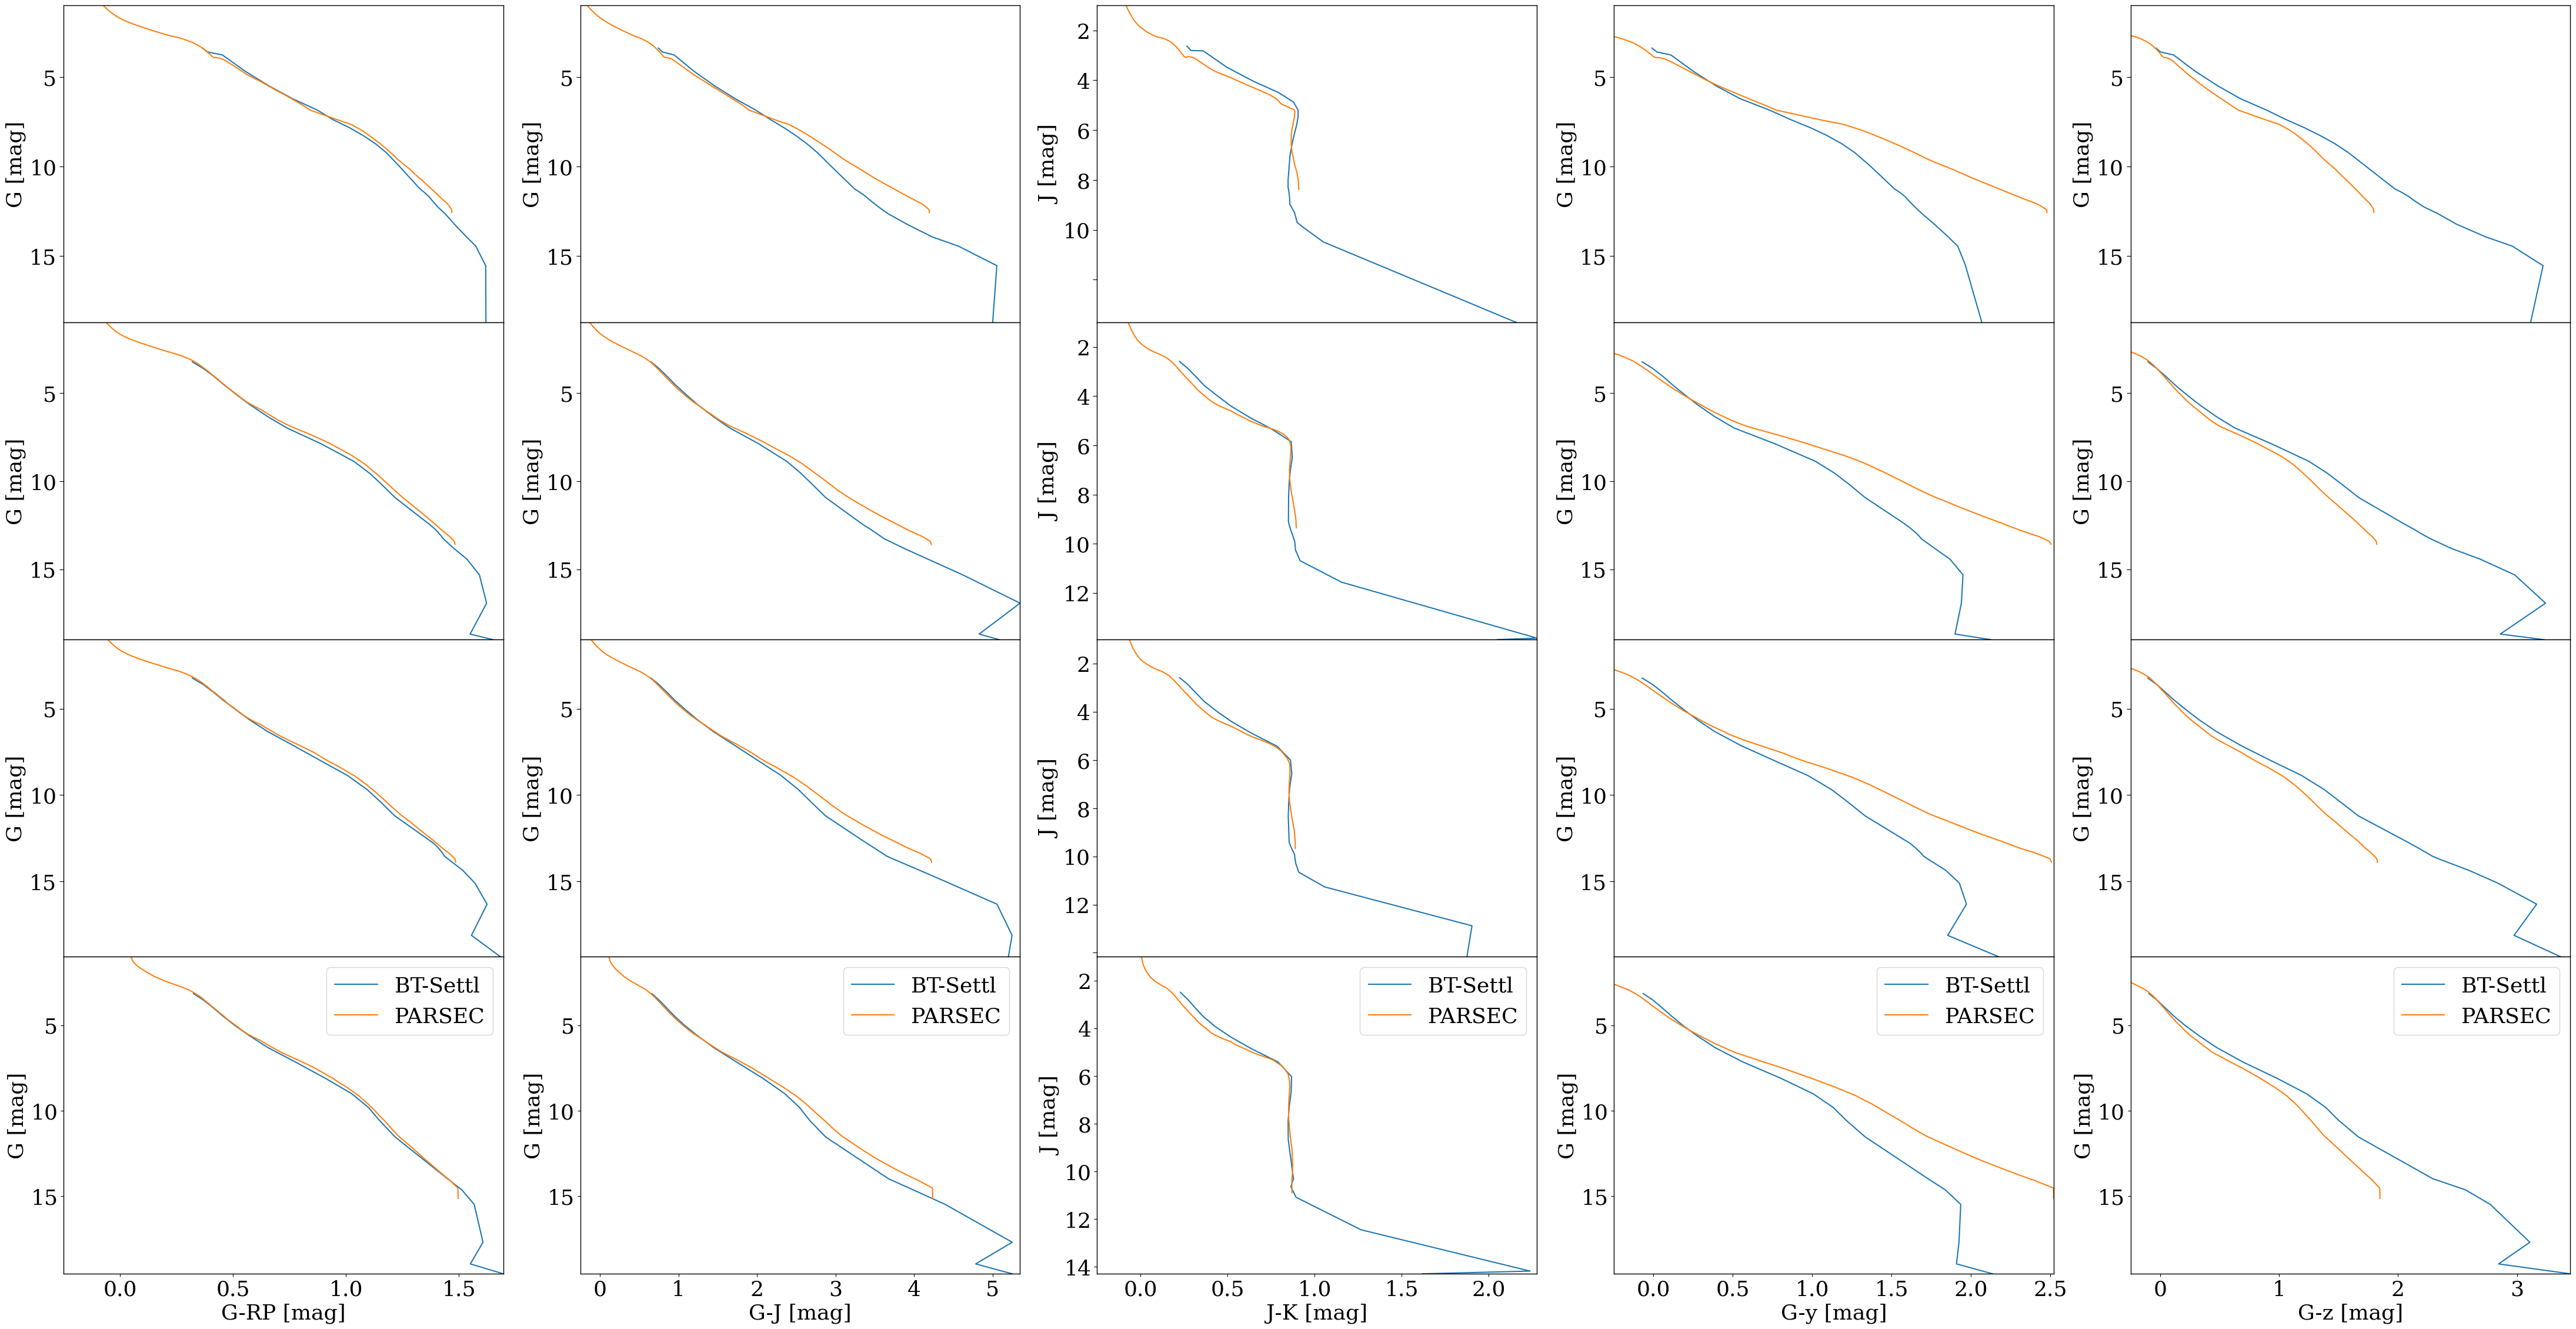

In [388]:
bands1 = [['G', 'RP'], ['G', 'J'], ['J', 'K'], ['G', 'y'], ['G', 'z']]
bands2 = [['G_i00', 'G_RP_i00'], ['G_i00', 'J_i00'], ['J_i00', 'Ks_i00'], ['G_i00', 'yP1_i00'], ['G_i00', 'zP1_i00']]


def plot_isochrones_grid(model1_dict, model2_dict, bands1, bands2, mod1, mod2, filename=None, dpi=400):
    # Set the font size
    plt.rcParams.update({'font.size': 26})

    # Create the figure and subplots
    fig, axs = plt.subplots(4, 5, figsize=(55, 28), sharex='col')

    # List of isochrones to use
    isochrones = [0.02, 0.08, 0.12, 0.6]

    # Iterate over each column (band combination)
    for i, (band1, band2) in enumerate(zip(bands1, bands2)):
        # Initialize variables to store the maximum and minimum x-axis values for this column
        max_x_column = float('-inf')
        max_y = float('-inf')

        # Iterate over each row (isochrone)
        for j, isochrone in enumerate(isochrones):
            ax = axs[j, i]
            ax.plot(model1_dict[isochrone][band1[0]] - model1_dict[isochrone][band1[1]], 
                    model1_dict[isochrone][band1[0]], label=f'{mod1}')
            isochrone_parsec = min(model2_dict.keys(), key=lambda x: abs(x - isochrone))
            ax.plot(model2_dict[isochrone_parsec][band2[0]] - model2_dict[isochrone_parsec][band2[1]], 
                    model2_dict[isochrone_parsec][band2[0]], label=f'{mod2}')
            
            max_x_column = max(max_x_column, np.max(model1_dict[isochrone][band1[0]] - model1_dict[isochrone][band1[1]]),
                   np.max(model2_dict[isochrone_parsec][band2[0]] - model2_dict[isochrone_parsec][band2[1]]))
            print(f"Max x value for column {i}: {max_x_column}")
            max_y = max(max_y, np.max(model1_dict[isochrone][band1[0]]), np.max(model2_dict[isochrone_parsec][band2[0]]))
        
            
            # Set labels and axes adjustments
            if j == 3:  # Only the last row has labels and ticks
                ax.set_xlabel(f'{band1[0]}-{band1[1]} [mag]')
                ax.set_ylabel(f'{band1[0]} [mag]')
                ax.xaxis.set_major_locator(ticker.AutoLocator())
                ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
                ax.legend()

            else:  # Hide labels and ticks for other rows
                ax.set_ylabel(f'{band1[0]} [mag]')
                ax.set_xticklabels([])
                ax.tick_params(axis='both', which='both', length=5)
                ax.yaxis.get_major_ticks()[0].label1.set_visible(False)

            ax.set_xlim(-0.25, max_x_column)
            ax.set_ylim(1, max_y)
            ax.invert_yaxis()
            
             
    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0, wspace=0.175)
    
    # Save the plot
    if filename:
        plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Example usage
plot_isochrones_grid(BTSettl_Li_isochrones, PARSEC_iso_omega_06_Phot_dict, bands1, bands2, 'BT-Settl', 'PARSEC', filename='model_comparison.png')

